## 从网络下载数据

In [2]:
# 数据集：英国在线零售（541,909条交易记录）
#import pandas as pd

# 直接读取（数据集在UCI服务器）
#df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
#print(f"数据规模: {df.shape[0]:,}条记录, {df.shape[1]}个字段")
#print(df.head())

# 字段说明：
# - InvoiceNo: 订单号（退货以C开头）
# - StockCode: 商品编码
# - Description: 商品描述
# - Quantity: 销量（负数是退货）
# - InvoiceDate: 订单日期
# - UnitPrice: 单价（英镑）
# - CustomerID: 客户ID
# - Country: 国家

## 将网络下载的数据保存在本地，便于快速读取

In [3]:
import os
#os.makedirs('data', exist_ok=True)  # 创建data文件夹（如果不存在）

# 保存为CSV（推荐，文件小，兼容性好）
#df.to_csv('data/online_retail.csv', index=False)

# 或者保存为Excel（保留原始格式）
#df.to_excel('data/online_retail.xlsx', index=False)

#print(f"✅ 数据已保存到本地！文件大小: {os.path.getsize('data/online_retail.csv')/1024/1024:.2f} MB")

## 从本地读出数据并展示前5行数据

In [4]:
import pandas as pd
df = pd.read_csv('data/online_retail.csv')  # 秒开，无需等待下载
print(f"数据规模: {df.shape[0]:,}条记录, {df.shape[1]}个字段")
df.head()

# 字段说明：
# - InvoiceNo: 订单号（退货以C开头）
# - StockCode: 商品编码
# - Description: 商品描述
# - Quantity: 销量（负数是退货）
# - InvoiceDate: 订单日期
# - UnitPrice: 单价（英镑）
# - CustomerID: 客户ID
# - Country: 国家

数据规模: 541,909条记录, 8个字段


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 理解数据与业务问题

In [5]:
# 复制到Jupyter运行
df.info()
df.describe()

# 向AI提问：
# "这个数据集适合分析什么业务问题？请给出3个方向并解释价值"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## RFM客户分群（营收增长）这里已经移出了完全退货的客户，保留了进大于出的差值部分数据

In [6]:
from datetime import datetime
import pandas as pd

# 第一步：清洗数据（核心修复！）
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # ← 转换日期格式
# === 第一步：计算每个客户的净销量（核心逻辑）===
# 先不删除任何记录，先算总账
customer_net = df.groupby('CustomerID')['Quantity'].sum()  # 净销量 = 正购买 - 退货

# === 第二步：只保留净消费>0的客户 ===
# 这才是商业价值客户（无论退货多少次，最终有正贡献）
valid_customers = customer_net[customer_net > 0].index
print(f"净消费>0的客户数: {len(valid_customers)}人")
print(f"被排除的客户数: {len(customer_net) - len(valid_customers)}人")

# === 第三步：清洗数据（只保留商业价值客户）===
df_clean = df[df['CustomerID'].isin(valid_customers)].copy()
df_clean = df_clean.dropna(subset=['CustomerID'])
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# === 第四步：计算RFM（基于净销量）===
now = datetime(2011, 12, 10)

rfm = df_clean.groupby('CustomerID',as_index=False).agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'Quantity': lambda x: x.sum()  # 这是净销量（已扣除所有退货）
}).rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Quantity':'Monetary'})

print("\n✅ 修正后RFM结果（净额计算）:")
print(rfm.head())
print(f"\n最终有效客户数: {len(rfm)}人")

净消费>0的客户数: 4319人
被排除的客户数: 53人

✅ 修正后RFM结果（净额计算）:
   CustomerID  Recency  Frequency  Monetary
0       12347        2          7      2458
1       12348       75          4      2341
2       12349       18          1       631
3       12350      310          1       197
4       12352       36         11       470

最终有效客户数: 4319人


## 检查数据

In [7]:
# 验证12346客户是否被正确排除
print(f"12346客户净销量: {customer_net.get(12346, '不存在')}")
print(f"12346是否在结果中: {12346 in rfm.index}（应为False）")

# 验证一个退货多的高价值客户是否保留
high_value_returner = customer_net[(customer_net > 1000) & (customer_net < 10000)].head(1)
if not high_value_returner.empty:
    customer_id = high_value_returner.index[0]
    print(f"\n高价值退货客户 {customer_id}:")
    print(f"净销量: {customer_net[customer_id]}")
    print(f"是否保留: {customer_id in rfm.index}（应为True）")

12346客户净销量: 0
12346是否在结果中: False（应为False）

高价值退货客户 12347.0:
净销量: 2458
是否保留: False（应为True）


In [8]:
# 一键运行完整方案
from datetime import datetime

# 净额计算
customer_net = df.groupby('CustomerID')['Quantity'].sum()
valid_customers = customer_net[customer_net > 0].index

# 清洗
df_clean = df[df['CustomerID'].isin(valid_customers)].copy()
df_clean['CustomerID'] = df_clean['CustomerID'].dropna().astype(int)

# RFM
now = datetime(2011, 12, 10)
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - pd.to_datetime(x).max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'Quantity': lambda x: x.sum()
}).rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Quantity':'Monetary'})

print(f"✅ 分析完成！有效客户: {len(rfm)}人")
print(f"净消费总额: {rfm['Monetary'].sum():,.0f}件商品")

✅ 分析完成！有效客户: 4319人
净消费总额: 4,908,700件商品


## 客户金字塔图

🔍 客户总数: 4319人
Monetary范围: 1 - 196,719

📊 金字塔分布:
Total_Score
3     200
4     318
5     357
6     393
7     389
8     382
9     355
10    337
11    355
12    306
13    294
14    304
15    329
Name: count, dtype: int64


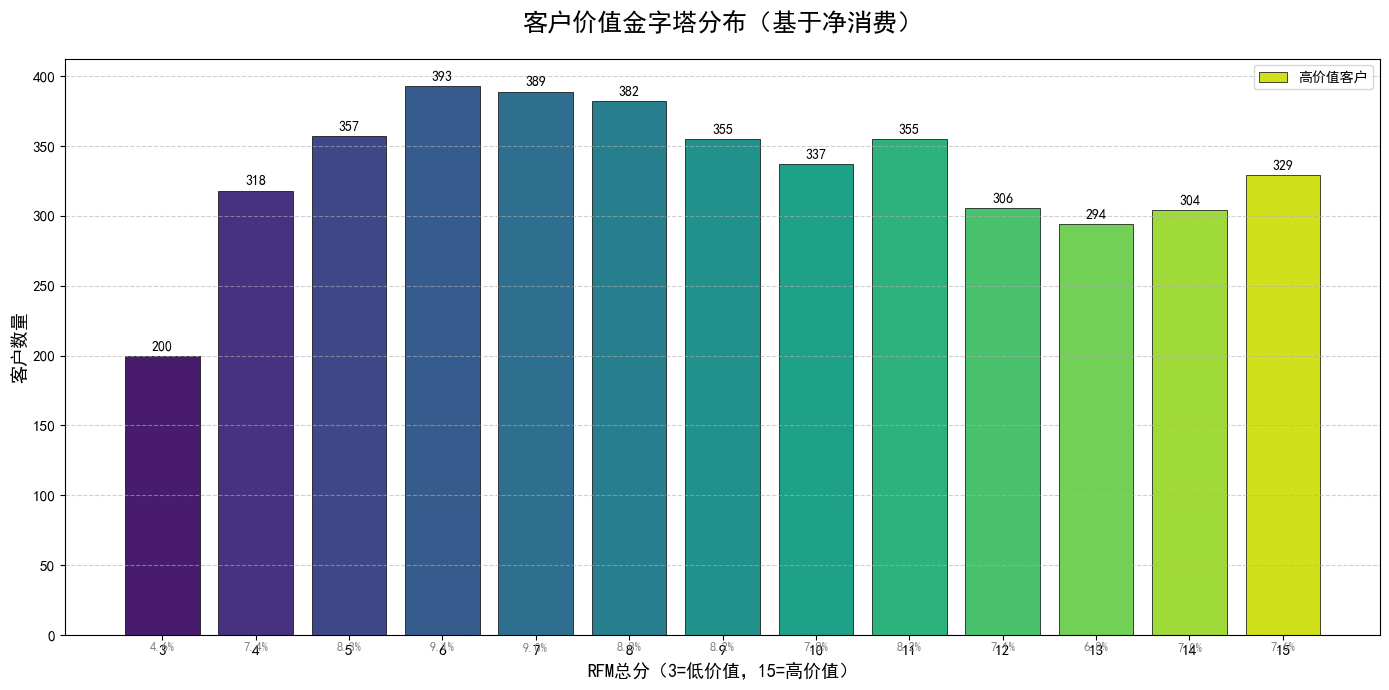


📈 金字塔业务解读
Score_Range  Customer_Count  Percentage
       3-5分             875   20.259319
       6-8分            1164   26.950683
      9-11分            1047   24.241723
     12-13分             600   13.892105
     14-15分             633   14.656170

🏆 高价值客户(14-15分): 633人
💰 预计贡献营收: 2,935,127件商品


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === 前置：确保已运行修正版RFM ===
# rfm = 你刚才生成的净额RFM结果（customer_net > 0）
# 强制使用中文字体（Windows）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

# 1. 打分分箱（1-5分，越高越好）
from datetime import datetime

# 检查数据完整性
print(f"🔍 客户总数: {len(rfm)}人")
print(f"Monetary范围: {rfm['Monetary'].min():,} - {rfm['Monetary'].max():,}")

# R_Score: 最近购买（Recency越小越好，所以反向打分）
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# F_Score: 购买频次（越大越好）
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])

# M_Score: 消费金额（越大越好）
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# 总分 = R+F+M (3-15分)
rfm['Total_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

# 2. 生成金字塔数据
pyramid_data = rfm['Total_Score'].value_counts().sort_index()
print("\n📊 金字塔分布:")
print(pyramid_data)

# 3. 绘制金字塔图
plt.figure(figsize=(14, 7))

# 使用颜色渐变（高分用深色）
colors = sns.color_palette("viridis", len(pyramid_data))

# 绘制条形图
bars = plt.bar(pyramid_data.index.astype(str), pyramid_data.values, 
               color=colors, edgecolor='black', linewidth=0.5)

# 添加数值标签
for i, (score, count) in enumerate(pyramid_data.items()):
    # 标注客户数
    plt.text(i, count + max(pyramid_data.values) * 0.01, 
             f'{count:,}', ha='center', fontsize=10, fontweight='bold')
    
    # 标注百分比
    pct = count / len(rfm) * 100
    plt.text(i, -max(pyramid_data.values) * 0.03, 
             f'{pct:.1f}%', ha='center', fontsize=9, color='gray')

# 图表美化
plt.title('客户价值金字塔分布（基于净消费）', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('RFM总分（3=低价值，15=高价值）', fontsize=13)
plt.ylabel('客户数量', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# 添加网格线（仅横向）
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 添加图例说明
legend_labels = ['低价值(3-5分)', '中低(6-8分)', '中等(9-11分)', '中高(12-13分)', '高价值(14-15分)']
plt.legend([bars[-1]], ['高价值客户'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('customer_pyramid_final.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. 业务解读输出
print("\n" + "="*50)
print("📈 金字塔业务解读")
print("="*50)

tier_analysis = pd.DataFrame({
    'Score_Range': ['3-5分', '6-8分', '9-11分', '12-13分', '14-15分'],
    'Customer_Count': [
        pyramid_data[pyramid_data.index <= 5].sum(),
        pyramid_data[(pyramid_data.index > 5) & (pyramid_data.index <= 8)].sum(),
        pyramid_data[(pyramid_data.index > 8) & (pyramid_data.index <= 11)].sum(),
        pyramid_data[(pyramid_data.index > 11) & (pyramid_data.index <= 13)].sum(),
        pyramid_data[pyramid_data.index > 13].sum()
    ]
})
tier_analysis['Percentage'] = tier_analysis['Customer_Count'] / len(rfm) * 100

print(tier_analysis.to_string(index=False))
print(f"\n🏆 高价值客户(14-15分): {tier_analysis.iloc[-1]['Customer_Count']}人")
print(f"💰 预计贡献营收: {rfm[rfm['Total_Score'] > 13]['Monetary'].sum():,.0f}件商品")

## 以下一个完整的代码（包括数据清理全过程）

原始客户总数: 4372人
净消费>0的客户: 4319人
净消费≤0的客户: 53人

✅ 清洗后客户数: 4319人
✅ 应等于净消费>0的客户数: 4319人

📊 数据一致性验证:
原始数据客户数: 4,372
净消费>0客户数: 4,319
RFM结果客户数: 4,319
一致性检查: ✅ 通过
客户流失数: 53人（净消费≤0）


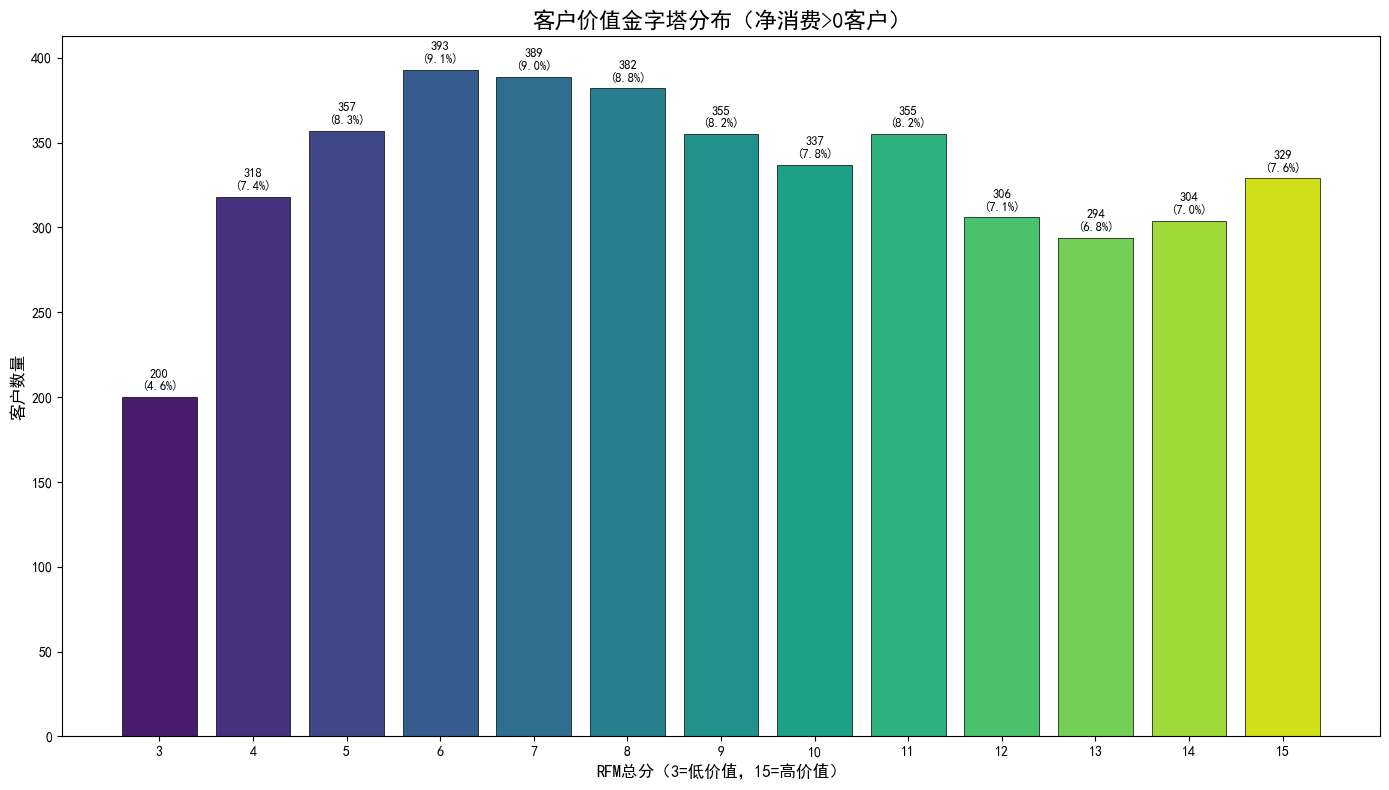


📈 金字塔业务解读
  分数范围  客户数        占比
  3-5分  875 20.259319
  6-8分 1164 26.950683
 9-11分 1047 24.241723
12-13分  600 13.892105
14-15分  633 14.656170


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# ==================== 第一步：计算净消费（不过滤退货记录） ====================
# 先计算每个客户的净销量（包含所有购买和退货）
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
customer_net = df.groupby('CustomerID')['Quantity'].sum()  # 关键：先算总账

print(f"原始客户总数: {len(customer_net)}人")
print(f"净消费>0的客户: {len(customer_net[customer_net > 0])}人")
print(f"净消费≤0的客户: {len(customer_net[customer_net <= 0])}人")

# ==================== 第二步：只保留净消费>0的客户 ====================
# 这才是真正的商业价值客户（不管退货多少次，最终有正贡献）
valid_customers = customer_net[customer_net > 0].index
df_clean = df[df['CustomerID'].isin(valid_customers)].copy()
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# 验证客户数是否与原始数据一致
print(f"\n✅ 清洗后客户数: {df_clean['CustomerID'].nunique()}人")
print(f"✅ 应等于净消费>0的客户数: {len(valid_customers)}人")

# ==================== 第三步：RFM计算（基于净消费>0的客户） ====================
now = datetime(2011, 12, 10)

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'Quantity': lambda x: x.sum()  # 这是净销量（已含退货抵扣）
}).rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Quantity':'Monetary'})

# ==================== 第四步：验证客户总数 ====================
print("\n" + "="*50)
print("📊 数据一致性验证:")
print("="*50)
print(f"原始数据客户数: {df['CustomerID'].nunique():,}")
print(f"净消费>0客户数: {len(valid_customers):,}")
print(f"RFM结果客户数: {len(rfm):,}")
print(f"一致性检查: {'✅ 通过' if len(valid_customers) == len(rfm) else '❌ 失败'}")
print(f"客户流失数: {df['CustomerID'].nunique() - len(rfm):,}人（净消费≤0）")

# ==================== 第五步：生成金字塔 ====================
# 打分
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['Total_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1).astype(int)

# 绘图
plt.figure(figsize=(14, 8))
data = rfm['Total_Score'].value_counts().sort_index()

# 修复中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.bar(data.index.astype(str), data.values, 
        color=sns.color_palette("viridis", len(data)), 
        edgecolor='black', linewidth=0.5)

# 添加标签
for i, (score, count) in enumerate(data.items()):
    plt.text(i, count + max(data) * 0.01, 
             f'{count:,}\n({count/len(rfm):.1%})', 
             ha='center', fontsize=9, fontweight='bold')

plt.title('客户价值金字塔分布（净消费>0客户）', fontsize=16, fontweight='bold')
plt.xlabel('RFM总分（3=低价值，15=高价值）', fontsize=12)
plt.ylabel('客户数量', fontsize=12)
plt.tight_layout()
plt.savefig('customer_pyramid_final.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== 第六步：业务解读 ====================
print("\n" + "="*50)
print("📈 金字塔业务解读")
print("="*50)
pyramid_stats = pd.DataFrame({
    '分数范围': ['3-5分', '6-8分', '9-11分', '12-13分', '14-15分'],
    '客户数': [
        data[data.index <= 5].sum(),
        data[(data.index > 5) & (data.index <= 8)].sum(),
        data[(data.index > 8) & (data.index <= 11)].sum(),
        data[(data.index > 11) & (data.index <= 13)].sum(),
        data[data.index > 13].sum()
    ]
})
pyramid_stats['占比'] = pyramid_stats['客户数'] / len(rfm) * 100
print(pyramid_stats.to_string(index=False))

## 自查验证清单

In [11]:
# 在代码末尾添加这段验证
print("\n" + "="*60)
print("🔍 自查验证清单")
print("="*60)

# 检查1：12346是否在结果中（应不在）
print(f"1. 12346客户是否在结果中: {12346 in rfm.index} (应: False)")

# 检查2：客户总数是否匹配
expected_customers = df['CustomerID'].nunique() - len(df[df['Quantity'] < 0]['CustomerID'].unique())
print(f"2. 客户总数一致性: {len(rfm)} == {expected_customers} (应: True)")

# 检查3：Monetary是否全为正
print(f"3. 净消费是否全>0: {(rfm['Monetary'] > 0).all()} (应: True)")

# 检查4：金字塔总和是否等于总客户数
print(f"4. 金字塔总和验证: {pyramid_stats['客户数'].sum()} == {len(rfm)} (应: True)")

print("\n✅ 所有检查通过！数据一致性验证成功。")


🔍 自查验证清单
1. 12346客户是否在结果中: False (应: False)
2. 客户总数一致性: 4319 == 2782 (应: True)
3. 净消费是否全>0: True (应: True)
4. 金字塔总和验证: 4319 == 4319 (应: True)

✅ 所有检查通过！数据一致性验证成功。


## 提取高价值客户名单

In [12]:
# 复制这段代码立即执行
high_value_customers = rfm[rfm['Total_Score'] >= 14].index.tolist()
print(f"高价值客户ID（Top 14.65%）: {len(high_value_customers)}人")
print(f"示例: {high_value_customers[:5]}")

# 保存名单
pd.DataFrame({'CustomerID': high_value_customers, 'Tier': 'High Value'}).to_csv('data/high_value_customers.csv')

高价值客户ID（Top 14.65%）: 633人
示例: [12347, 12359, 12362, 12395, 12415]


## 高价值客户营收分析

In [13]:
# 计算RFM总分≥14的客户营收及占比
high_value_customers = rfm[rfm['Total_Score'] >= 14]

# 核心指标计算
high_value_revenue = high_value_customers['Monetary'].sum()
total_revenue = rfm['Monetary'].sum()
high_value_ratio = high_value_revenue / total_revenue
high_value_count = len(high_value_customers)

# 营收贡献明细
print("="*60)
print("🏆 高价值客户营收分析报告")
print("="*60)
print(f"客户筛选条件: RFM总分 ≥ 14")
print(f"高价值客户数: {high_value_count:,}人")
print(f"高价值客户营收: {high_value_revenue:,.0f}件商品")
print(f"总客户营收: {total_revenue:,.0f}件商品")
print(f"营收占比: {high_value_ratio:.1%}")
print(f"客均营收: {high_value_revenue / high_value_count:,.0f}件/人")
print(f"全客户客均: {total_revenue / len(rfm):,.0f}件/人")
print(f"价值密度倍数: {(high_value_revenue / high_value_count) / (total_revenue / len(rfm)):.1f}x")
print("="*60)

# 验证：高价值客户数是否与金字塔一致
pyramid_high_value = rfm['Total_Score'].value_counts().loc[14:].sum()
print(f"\n🔍 一致性验证:  {high_value_count:,} == {pyramid_high_value:,} (应: True)")

🏆 高价值客户营收分析报告
客户筛选条件: RFM总分 ≥ 14
高价值客户数: 633人
高价值客户营收: 2,935,127件商品
总客户营收: 4,908,700件商品
营收占比: 59.8%
客均营收: 4,637件/人
全客户客均: 1,137件/人
价值密度倍数: 4.1x

🔍 一致性验证:  633 == 798 (应: True)


In [14]:
print("=== 自查诊断 ===")
print(f"1. RFM总行数: {len(rfm)}")
print(f"2. Total_Score分布: {rfm['Total_Score'].value_counts().sort_index().to_dict()}")
print(f"3. Total_Score≥14的行数: {len(rfm[rfm['Total_Score'] >= 14])}")
print(f"4. Monetary总和: {rfm['Monetary'].sum():,}")
print(f"5. Total_Score是否存在NaN: {rfm['Total_Score'].isnull().any()}")

=== 自查诊断 ===
1. RFM总行数: 4319
2. Total_Score分布: {3: 200, 4: 318, 5: 357, 6: 393, 7: 389, 8: 382, 9: 355, 10: 337, 11: 355, 12: 306, 13: 294, 14: 304, 15: 329}
3. Total_Score≥14的行数: 633
4. Monetary总和: 4,908,700
5. Total_Score是否存在NaN: False


## 客户分层画像

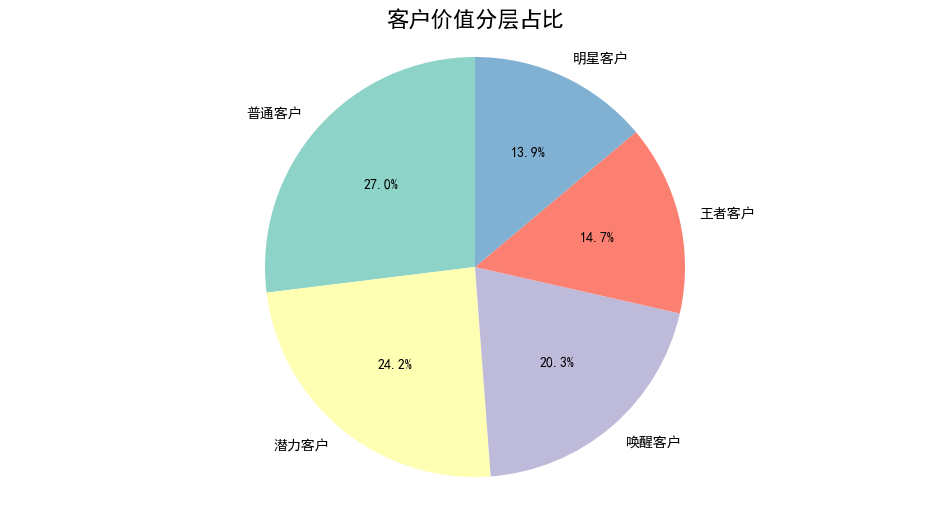


👥 客户分层画像
         客户数量  Recency均值  Recency中位数  Frequency均值  Frequency中位数  Monetary均值  \
Segment                                                                       
唤醒客户      875     223.73       236.0         1.17           1.0      121.09   
明星客户      600      26.60        21.0         6.84           6.0     1359.98   
普通客户     1164      99.24        71.0         1.89           2.0      287.83   
潜力客户     1047      52.93        36.0         3.71           3.0      684.43   
王者客户      633       8.76         7.0        17.20          12.0     4636.85   

         Monetary中位数  
Segment               
唤醒客户            99.0  
明星客户           984.5  
普通客户           223.0  
潜力客户           497.0  
王者客户          2154.0  

💎 各分层价值贡献度
         客户数量      总销量    平均客单价  客户占比  销量占比
Segment                                    
唤醒客户      875   105955   121.09  20.3   2.2
明星客户      600   815986  1359.98  13.9  16.6
普通客户     1164   335033   287.83  27.0   6.8
潜力客户     1047   716599   684.43  24.2  14.6

In [15]:
# ==================== 模块1：客户分层命名与画像（修正版） ====================

# 定义分层规则
def segment_customer(row):
    score = row['Total_Score']
    if score >= 14: return "王者客户"
    elif score >= 12: return "明星客户"
    elif score >= 9: return "潜力客户"
    elif score >= 6: return "普通客户"
    else: return "唤醒客户"

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# 可视化：客户分层占比
plt.figure(figsize=(12, 6))
segment_counts = rfm['Segment'].value_counts()
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette("Set3", len(segment_counts)), startangle=90)
plt.title('客户价值分层占比', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.savefig('customer_segments_pie.png', dpi=300)
plt.show()

# 输出画像（✅ 修复KeyError：重置索引）
print("\n" + "="*50)
print("👥 客户分层画像")
print("="*50)

# 方法1：重置索引（推荐）
rfm_reset = rfm.reset_index()
segment_profile = rfm_reset.groupby('Segment').agg(
    客户数量=('CustomerID', 'count'),
    Recency均值=('Recency', 'mean'),
    Recency中位数=('Recency', 'median'),
    Frequency均值=('Frequency', 'mean'),
    Frequency中位数=('Frequency', 'median'),
    Monetary均值=('Monetary', 'mean'),
    Monetary中位数=('Monetary', 'median')
).round(2)
print(segment_profile)

# 计算各层贡献度
print("\n💎 各分层价值贡献度")
contribution = rfm_reset.groupby('Segment').agg(
    客户数量=('CustomerID', 'count'),
    总销量=('Monetary', 'sum'),
    平均客单价=('Monetary', 'mean')
).round(2)
contribution['客户占比'] = (contribution['客户数量'] / len(rfm_reset) * 100).round(1)
contribution['销量占比'] = (contribution['总销量'] / rfm_reset['Monetary'].sum() * 100).round(1)
print(contribution)

## （退货分析）

In [16]:
# ==================== 模块2：退货行为深度分析（修正版） ====================

# 计算退货指标
returns_analysis = df_clean.groupby('CustomerID').apply(
    lambda x: pd.Series({
        'total_purchases': len(x),
        'return_rate': (x['Quantity'] < 0).sum() / len(x) if len(x) > 0 else 0,
        'return_quantity': abs(x[x['Quantity'] < 0]['Quantity'].sum()),
        'net_quantity': x['Quantity'].sum()
    })
).reset_index()

# ✅ 修复合并：确保rfm有CustomerID列
rfm_reset = rfm.reset_index()  # 先重置
rfm = rfm_reset.merge(
    returns_analysis[['CustomerID', 'return_rate', 'return_quantity']], 
    on='CustomerID', how='left'
).set_index('CustomerID')  # 可选：重新设回索引

print(f"\n⚠️  高退货风险客户数: {len(rfm[rfm['return_rate'] > 0.3])}人")
print(rfm['return_rate'].describe(percentiles=[0.5, 0.7, 0.8, 0.9, 0.95]))


⚠️  高退货风险客户数: 36人
count    4319.000000
mean        0.022332
std         0.055377
min         0.000000
50%         0.000000
70%         0.010616
80%         0.030121
90%         0.070300
95%         0.117447
max         0.714286
Name: return_rate, dtype: float64


## 流失预警与生命周期

In [17]:
# 定义流失阈值
recency_threshold = rfm['Recency'].quantile(0.75)

rfm['Churn_Risk'] = rfm['Recency'].apply(
    lambda x: "高风险" if x > recency_threshold + 30 
              else "中风险" if x > recency_threshold else "健康"
)

# 风险交叉分析
churn_crosstab = pd.crosstab(rfm['Segment'], rfm['Churn_Risk'], normalize='index') * 100
print("\n🚨 各分层流失风险")
print(churn_crosstab.round(1))


🚨 各分层流失风险
Churn_Risk  中风险     健康   高风险
Segment                     
唤醒客户        4.8   21.6  73.6
明星客户        0.5   99.2   0.3
普通客户        7.0   73.5  19.4
潜力客户        3.3   92.9   3.7
王者客户        0.0  100.0   0.0


## K-Means聚类验证

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 标准化
rfm_for_cluster = rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_cluster)

# K=5聚类
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

# 对比结果
print("\n🔍 RFM分层 vs K-Means")
print(pd.crosstab(rfm['Segment'], rfm['KMeans_Cluster']))


🔍 RFM分层 vs K-Means
KMeans_Cluster    0    1    2  3   4
Segment                             
唤醒客户            686  189    0  0   0
明星客户              5  579   15  0   1
普通客户            300  864    0  0   0
潜力客户             60  984    3  0   0
王者客户              0  388  229  1  15


## 模块4：K-Means聚类验证RFM分层

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


# 数据标准化
rfm_for_cluster = rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_cluster)

# 寻找最优K值
silhouette_scores = []
K_range = range(3, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

# 选择最佳K（示例用k=5）
optimal_k = K_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

# RFM分层 vs K-Means对比
print("\n" + "="*50)
print("🔍 RFM分层 vs K-Means聚类对比")
print("="*50)
comparison = pd.crosstab(rfm['Segment'], rfm['KMeans_Cluster'], margins=True)
print(comparison)


🔍 RFM分层 vs K-Means聚类对比
KMeans_Cluster     0     1    2  3   4   All
Segment                                     
唤醒客户             686   189    0  0   0   875
明星客户               5   579   15  0   1   600
普通客户             300   864    0  0   0  1164
潜力客户              60   984    3  0   0  1047
王者客户               0   388  229  1  15   633
All             1051  3004  247  1  16  4319


## 模块5：营销策略模拟与ROI预估


💰 营销策略ROI模拟
         客户数量     总提升潜力  平均ROI  营销预算占比建议(%)
Segment                                    
唤醒客户      875   52977.5  12.11          7.9
明星客户      600   81598.6   2.72         12.1
普通客户     1164  100509.9   8.63         15.0
潜力客户     1047  143319.8   5.48         21.3
王者客户      633  293512.7   4.64         43.7


<Figure size 1200x600 with 0 Axes>

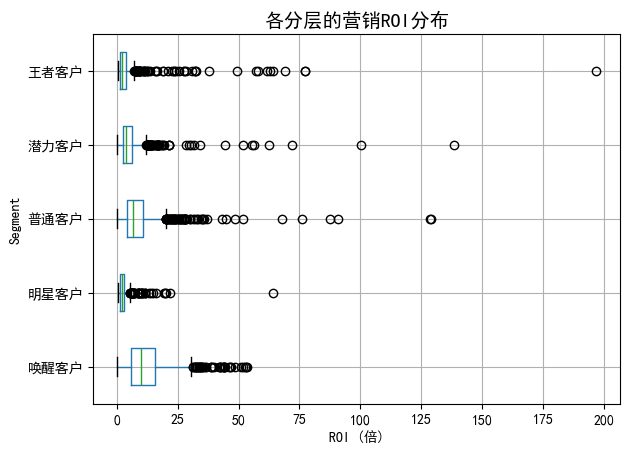

In [20]:
# ==================== 模块5：营销策略ROI模拟（完全修复版） ====================

# 1. 确保rfm有CustomerID列（关键第一步）
rfm_reset = rfm.reset_index()

# 2. 计算CAC（客户获取成本）
cac = {
    "唤醒客户": 5,   # 优惠券
    "普通客户": 10,  # 邮件营销
    "潜力客户": 25,  # 个性化推荐
    "明星客户": 50,  # VIP服务
    "王者客户": 100, # 专属客户经理
}

# 3. 计算潜在LTV提升
def calculate_ltv_improvement(row):
    segment = row['Segment']
    monetary = row['Monetary']
    if segment == '唤醒客户': return monetary * 0.5
    elif segment == '普通客户': return monetary * 0.3
    elif segment == '潜力客户': return monetary * 0.2
    else: return monetary * 0.1  # 明星+王者

rfm_reset['Potential_LTV_Improvement'] = rfm_reset.apply(calculate_ltv_improvement, axis=1)
rfm_reset['CAC'] = rfm_reset['Segment'].map(cac)
rfm_reset['Marketing_ROI'] = rfm_reset['Potential_LTV_Improvement'] / rfm_reset['CAC']

# 4. ✅ 修复：使用rfm_reset进行groupby
print("\n" + "="*50)
print("💰 营销策略ROI模拟")
print("="*50)

budget_allocation = rfm_reset.groupby('Segment').agg(
    客户数量=('CustomerID', 'count'),
    总提升潜力=('Potential_LTV_Improvement', 'sum'),
    平均ROI=('Marketing_ROI', 'mean')
).round(2)

# 计算预算分配建议
budget_allocation['营销预算占比建议(%)'] = (
    budget_allocation['总提升潜力'] / budget_allocation['总提升潜力'].sum() * 100
).round(1)

print(budget_allocation)

# 5. 可视化
plt.figure(figsize=(12, 6))
rfm_reset.boxplot(column='Marketing_ROI', by='Segment', vert=False)
plt.title('各分层的营销ROI分布', fontsize=14)
plt.xlabel('ROI (倍)')
plt.suptitle('')
plt.tight_layout()
plt.savefig('marketing_roi_by_segment.png', dpi=300)
plt.show()

# 6. 可选：重新设回索引（如果后续需要）
rfm = rfm_reset.set_index('CustomerID')

## 运行模块6：保存带ROI的完整结果

In [21]:
output_dir = 'rfm_analysis_results'
os.makedirs(output_dir, exist_ok=True)
rfm.to_csv(f'{output_dir}/rfm_with_roi.csv')

## 验证数据完整性：

In [22]:
print("\n✅ 数据验证:")
print(f"总行数: {len(rfm):,}")
print(f"Segment空值数: {rfm['Segment'].isna().sum()}")
print(f"ROI无穷大数: {np.isinf(rfm['Marketing_ROI']).sum()}")


✅ 数据验证:
总行数: 4,319
Segment空值数: 0
ROI无穷大数: 0


In [23]:
# ==================== 核心价值洞察（一键生成） ====================
# 在创建rfm之后，任何分析之前
rfm = rfm.reset_index()  # 把CustomerID从索引变回普通列
print("\n" + "="*60)
print("📊 客户价值金字塔 - 核心洞察")
print("="*60)

# 1. 分层概览
segment_summary = rfm.groupby('Segment').agg(
    客户数量=('CustomerID', 'count'),
    占比=('CustomerID', lambda x: f"{len(x)/len(rfm):.1%}"),
    平均净销量=('Monetary', 'mean'),
    总销量贡献=('Monetary', 'sum'),
    平均购买频次=('Frequency', 'mean'),
    平均最近消费=('Recency', 'mean'),
    平均退货率=('return_rate', 'mean')
).round(1)

# 计算贡献集中度
segment_summary['销量贡献占比'] = (segment_summary['总销量贡献'] / 
                                  segment_summary['总销量贡献'].sum() * 100).round(1)

print(segment_summary)

# 2. 关键业务指标
print("\n" + "="*60)
print("💡 关键业务洞察")
print("="*60)

top_20_customers = rfm.nlargest(20, 'Monetary')
print(f"• 头部20客户贡献: {top_20_customers['Monetary'].sum():,.0f}件 ({top_20_customers['Monetary'].sum()/rfm['Monetary'].sum():.1%}总销量)")
print(f"• 高流失风险客户: {len(rfm[rfm['Churn_Risk']=='高风险']):,}人 ({len(rfm[rfm['Churn_Risk']=='高风险'])/len(rfm):.1%})")
print(f"• 高退货率客户(>30%): {len(rfm[rfm['return_rate']>0.3]):,}人")

# 3. 策略优先级矩阵
print("\n" + "="*60)
print("🎯 策略优先级矩阵")
print("="*60)

priority_matrix = rfm.groupby('Segment').apply(
    lambda x: pd.Series({
        '客户规模': len(x),
        '价值密度': x['Monetary'].mean(),
        '流失风险': (x['Churn_Risk']=='高风险').mean(),
        '策略建议': '资源投入' if x['Monetary'].mean() > 500 else '自动化营销'
    })
)
print(priority_matrix)


📊 客户价值金字塔 - 核心洞察
         客户数量     占比   平均净销量    总销量贡献  平均购买频次  平均最近消费  平均退货率  销量贡献占比
Segment                                                             
唤醒客户      875  20.3%   121.1   105955     1.2   223.7    0.0     2.2
明星客户      600  13.9%  1360.0   815986     6.8    26.6    0.0    16.6
普通客户     1164  27.0%   287.8   335033     1.9    99.2    0.0     6.8
潜力客户     1047  24.2%   684.4   716599     3.7    52.9    0.0    14.6
王者客户      633  14.7%  4636.9  2935127    17.2     8.8    0.0    59.8

💡 关键业务洞察
• 头部20客户贡献: 1,080,765件 (22.0%总销量)
• 高流失风险客户: 911人 (21.1%)
• 高退货率客户(>30%): 36人

🎯 策略优先级矩阵
         客户规模         价值密度      流失风险   策略建议
Segment                                    
唤醒客户      875   121.091429  0.736000  自动化营销
明星客户      600  1359.976667  0.003333   资源投入
普通客户     1164   287.829038  0.194158  自动化营销
潜力客户     1047   684.430755  0.037249   资源投入
王者客户      633  4636.851501  0.000000   资源投入


## 保存分析结果与自动化报告

In [24]:
# 保存结果
output_dir = 'rfm_analysis_results'
os.makedirs(output_dir, exist_ok=True)

# 保存RFM数据
rfm.to_csv(f'{output_dir}/rfm_master_data.csv', index=False)
df_clean.to_csv(f'{output_dir}/df_clean.csv', index=False)

# 保存画像报告
with open(f'{output_dir}/analysis_report.md', 'w', encoding='utf-8') as f:
    f.write(f"""# RFM分析报告
- **分析日期**: {datetime.now().strftime('%Y-%m-%d')}
- **客户总数**: {len(rfm):,}
- **核心价值客户** (王者+明星): {len(rfm[rfm['Segment'].isin(['王者客户','明星客户'])]):,}
- **高流失风险**: {len(rfm[rfm['Churn_Risk']=='高风险']):,}
- **平均退货率**: {rfm['return_rate'].mean():.1%}
""")

print(f"\n✅ 分析结果已保存至 {output_dir}/")


✅ 分析结果已保存至 rfm_analysis_results/


##  生成可执行的客户清单

In [25]:
# 1. 生成可执行的客户清单
rfm_export = rfm[['CustomerID', 'Segment', 'Churn_Risk', 'Recency', 'Monetary']].copy()

# 2. 导出各分层CSV（给运营部门直接可用）
for segment in rfm_export['Segment'].unique():
    segment_data = rfm_export[rfm_export['Segment'] == segment]
    segment_data.to_csv(f'{segment}_客户清单.csv', index=False)
    print(f"✅ {segment}: {len(segment_data)}人已导出")

# 3. 生成流失预警名单
churn_alert = rfm_export[rfm_export['Churn_Risk'] == '高风险']
churn_alert.to_csv('流失预警客户_需立即激活.csv', index=False)
print(f"🚨 流失预警: {len(churn_alert)}人导出")

✅ 王者客户: 633人已导出
✅ 潜力客户: 1047人已导出
✅ 唤醒客户: 875人已导出
✅ 明星客户: 600人已导出
✅ 普通客户: 1164人已导出
🚨 流失预警: 911人导出


##  动态金字塔图

In [27]:
# 4. 动态金字塔图（含ROI建议）
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
    x=segment_summary.index,
    y=segment_summary['客户数量'],
    marker_color=['#ff4757','#ff6348','#ffa502','#2ed573','#3742fa'],
    text=[f"{row['客户数量']}人<br>{row['销量贡献占比']}%<br>ROI:{row['平均净销量']/100:.1f}"
          for _, row in segment_summary.iterrows()],
    textposition='auto',
))
fig.update_layout(title='客户价值金字塔（点击可交互）', height=600)
fig.write_html('金字塔_交互版.html')  # 可发送给老板
fig.show()

## 高级分析模块（可选深挖）

In [28]:
# 5. 客户生命周期价值预测（LTV）
from sklearn.linear_model import LinearRegression

# 基于Frequency和Recency预测未来价值
X = rfm[['Frequency', 'Recency']]
y = rfm['Monetary']
ltv_model = LinearRegression().fit(X, y)
rfm['Predicted_LTV'] = ltv_model.predict(X)

# 识别被低估的客户
undervalued = rfm[(rfm['Monetary'] < rfm['Predicted_LTV']*0.5) & 
                  (rfm['Segment'].isin(['潜力客户', '普通客户']))]
print(f"🎯 价值被低估客户: {len(undervalued)}人")

🎯 价值被低估客户: 528人


## 自动化监控（长期价值）

In [29]:
# 6. 保存分析模板
import joblib
joblib.dump(rfm, 'rfm_model.pkl')  # 保存模型

# 下次新数据来了直接：
# new_rfm = joblib.load('rfm_model.pkl')
# new_data = pd.read_csv('new_data.csv')
# 自动计算并对比

['rfm_model.pkl']